In [1]:
!pip3 install arch


   ---------------------------------------- 923.5/923.5 kB 1.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
sns.set()

## For statistical insights
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats.distributions import chi2 

## For ARCH Modelling
from arch import arch_model
print("Necessary packages imported successfully!")

Necessary packages imported successfully!


In [4]:
url = 'LSTM-Multivariate_pollution.csv'
raw_csv_data = pd.read_csv(url,error_bad_lines=False)
raw_csv_data.head(10)


,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0
5,2010-01-02 05:00:00,109.0,-7,-6.0,1022.0,SE,7.14,3,0
6,2010-01-02 06:00:00,105.0,-7,-6.0,1023.0,SE,8.93,4,0
7,2010-01-02 07:00:00,124.0,-7,-5.0,1024.0,SE,10.72,0,0
8,2010-01-02 08:00:00,120.0,-8,-6.0,1024.0,SE,12.51,0,0
9,2010-01-02 09:00:00,132.0,-7,-5.0,1025.0,SE,14.30,0,0


In [5]:
df_comp=raw_csv_data.copy()
df_comp.date = pd.to_datetime(df_comp.date, dayfirst = True)
df_comp.set_index("date", inplace=True)
df_comp=df_comp.asfreq('b')
df_comp=df_comp.fillna(method='ffill')

del df_comp['dew']
del df_comp['temp']
del df_comp['press']
del df_comp['wnd_spd']
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

In [6]:
def LLR_test(mod_1, mod_2, DF = 1):
    L1 = mod_1.fit(start_ar_lags = 11).llf
    L2 = mod_2.fit(start_ar_lags = 11).llf
    LR = (2*(L2-L1))    
    p = chi2.sf(LR, DF).round(3)
    return p


In [7]:
df['press'] = df.pollution.pct_change(1)*100


In [8]:
df['wnd_spd'] = df.pollution.mul(df.pollution)


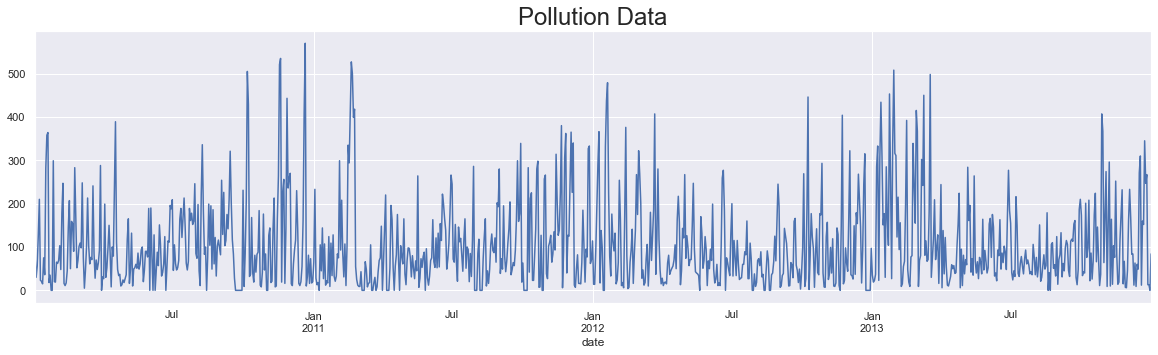

In [9]:
df.pollution.plot(figsize=(20,5))
plt.title("Pollution Data", size = 24)
plt.show()


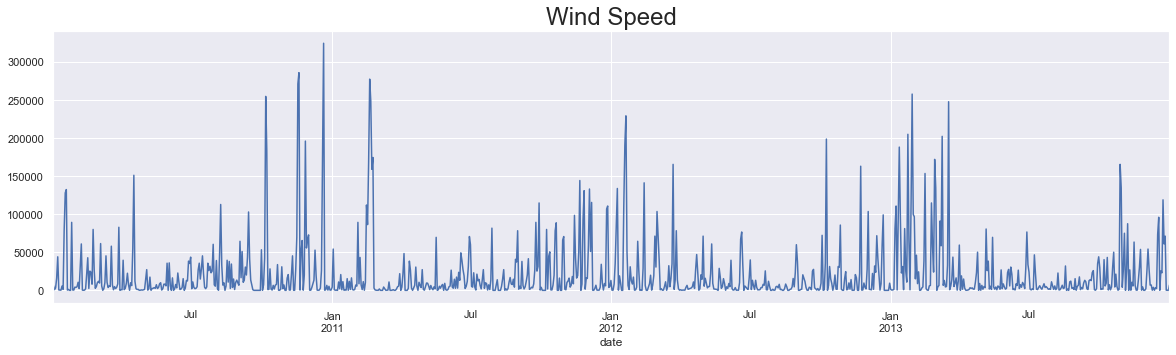

In [10]:
df.wnd_spd.plot(figsize=(20,5))
plt.title("Wind Speed", size = 24)
plt.show()


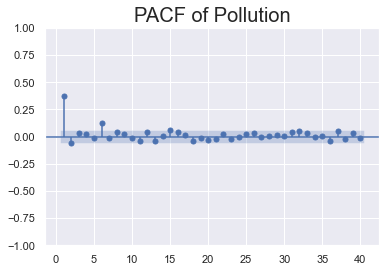

In [11]:
sgt.plot_pacf(df.pollution[1:], lags = 40, alpha = 0.05, zero = False , method = ('ols'))
plt.title("PACF of Pollution", size = 20)
plt.show()

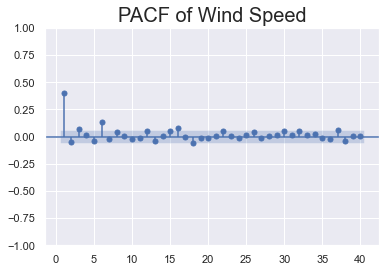

In [12]:
sgt.plot_pacf(df.wnd_spd[1:], lags = 40, alpha = 0.05, zero = False , method = ('ols'))
plt.title("PACF of Wind Speed", size = 20)
plt.show()

In [13]:
model_arch_1 = arch_model(df.pollution[1:])
results_arch_1 = model_arch_1.fit(update_freq = 5)
results_arch_1.summary()

Iteration:      5,   Func. Count:     31,   Neg. LLF: 6202.162876529188
Iteration:     10,   Func. Count:     56,   Neg. LLF: 6202.151421074164
Iteration:     15,   Func. Count:     81,   Neg. LLF: 6202.082900263611
Iteration:     20,   Func. Count:    106,   Neg. LLF: 6190.2087644027715
Iteration:     25,   Func. Count:    131,   Neg. LLF: 6190.146179969708
Iteration:     30,   Func. Count:    156,   Neg. LLF: 6190.103164313817
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6190.10297439816
            Iterations: 33
            Function evaluations: 173
            Gradient evaluations: 33


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:              pollution   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6190.10
Distribution:                  Normal   AIC:                           12388.2
Method:            Maximum Likelihood   BIC:                           12408.0
                                        No. Observations:                 1041
Date:                Fri, Jan 05 2024   Df Residuals:                     1040
Time:                        10:22:58   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            87.3078      4.388     19.896  4.446e-88 [ 78.707, 95.909]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega       5585.7753   1172.578      4.764  1.901e-06 [3.288e+03,7.884e+03]
alpha[1]       0.4985      0.143      3.494  4.761e-04     [  0.219,  0.778]
beta[1]    1.7965e-11      0.153  1.176e-10      1.000     [ -0.299,  0.299]
============================================================================

Covariance estimator: robust
"""

In [14]:
model_arch_1 = arch_model(df.pollution[1:], mean = "Constant", vol = "ARCH", p = 1)
results_arch_1 = model_arch_1.fit(update_freq = 5)
results_arch_1.summary()

Iteration:      5,   Func. Count:     23,   Neg. LLF: 6190.954537385478
Iteration:     10,   Func. Count:     43,   Neg. LLF: 6190.9512959772
Iteration:     15,   Func. Count:     63,   Neg. LLF: 6190.115481783496
Iteration:     20,   Func. Count:     82,   Neg. LLF: 6190.102971308078
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6190.102971308075
            Iterations: 20
            Function evaluations: 82
            Gradient evaluations: 20


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:              pollution   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -6190.10
Distribution:                  Normal   AIC:                           12386.2
Method:            Maximum Likelihood   BIC:                           12401.0
                                        No. Observations:                 1041
Date:                Fri, Jan 05 2024   Df Residuals:                     1040
Time:                        10:23:09   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            87.3071      4.063     21.489 1.983e-102 [ 79.344, 95.270]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega       5586.5947    596.953      9.359  8.087e-21 [4.417e+03,6.757e+03]
alpha[1]       0.4985      0.104      4.779  1.762e-06     [  0.294,  0.703]
============================================================================

Covariance estimator: robust
"""

In [15]:
model_arch_1 = arch_model(df.pollution[1:], mean = "AR", lags = [2, 3, 6], vol = "ARCH", p = 1, dist = "ged")
results_arch_1 = model_arch_1.fit(update_freq = 5)
results_arch_1.summary()

Iteration:      5,   Func. Count:     51,   Neg. LLF: 6126.0900767095045
Iteration:     10,   Func. Count:     96,   Neg. LLF: 6117.0519703840255
Iteration:     15,   Func. Count:    136,   Neg. LLF: 6111.783050340409
Iteration:     20,   Func. Count:    178,   Neg. LLF: 6111.763749734918
Iteration:     25,   Func. Count:    218,   Neg. LLF: 6111.763353946979
Iteration:     30,   Func. Count:    258,   Neg. LLF: 6111.754229839833
Iteration:     35,   Func. Count:    300,   Neg. LLF: 6111.71962070667
Iteration:     40,   Func. Count:    340,   Neg. LLF: 6111.516744597062
Iteration:     45,   Func. Count:    380,   Neg. LLF: 6110.62031017082
Iteration:     50,   Func. Count:    422,   Neg. LLF: 6110.601212146407
Iteration:     55,   Func. Count:    464,   Neg. LLF: 6110.618947678088
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6110.598985954002
            Iterations: 57
            Function evaluations: 484
            Gradient evaluations: 5

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 AR - ARCH Model Results                                  
==========================================================================================
Dep. Variable:                          pollution   R-squared:                      -0.100
Mean Model:                                    AR   Adj. R-squared:                 -0.103
Vol Model:                                   ARCH   Log-Likelihood:               -6110.60
Distribution:      Generalized Error Distribution   AIC:                           12235.2
Method:                        Maximum Likelihood   BIC:                           12269.8
                                                    No. Observations:                 1035
Date:                            Fri, Jan 05 2024   Df Residuals:                     1031
Time:                                    10:23:26   Df Model:                            4
                                   Mean Model                                   
================================================================================
                   coef    std err          t      P>|t|        95.0% Conf. Int.
--------------------------------------------------------------------------------
Const           67.2634      1.250     53.831      0.000       [ 64.814, 69.712]
pollution[2] 2.2475e-03  4.118e-02  5.457e-02      0.956  [-7.847e-02,8.297e-02]
pollution[3]    -0.0140  6.452e-03     -2.170  2.998e-02 [-2.665e-02,-1.358e-03]
pollution[6]     0.0546  6.673e-02      0.818      0.413    [-7.621e-02,  0.185]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega       5234.0643    524.186      9.985  1.771e-23 [4.207e+03,6.261e+03]
alpha[1]       0.6114      0.124      4.939  7.848e-07     [  0.369,  0.854]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             1.1301  9.588e-02     11.786  4.603e-32 [  0.942,  1.318]
========================================================================

Covariance estimator: robust
"""

In [16]:
model_arch_2 = arch_model(df.pollution[1:], mean = "Constant", vol = "ARCH", p = 2)
results_arch_2 = model_arch_2.fit(update_freq = 5)
results_arch_2.summary()

Iteration:      5,   Func. Count:     28,   Neg. LLF: 6190.961214369914
Iteration:     10,   Func. Count:     53,   Neg. LLF: 6190.953965551211
Iteration:     15,   Func. Count:     78,   Neg. LLF: 6190.584400469417
Iteration:     20,   Func. Count:    103,   Neg. LLF: 6190.102972038872
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6190.102972038872
            Iterations: 21
            Function evaluations: 107
            Gradient evaluations: 21


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:              pollution   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -6190.10
Distribution:                  Normal   AIC:                           12388.2
Method:            Maximum Likelihood   BIC:                           12408.0
                                        No. Observations:                 1041
Date:                Fri, Jan 05 2024   Df Residuals:                     1040
Time:                        10:23:38   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            87.3077      4.084     21.379 2.109e-101 [ 79.303, 95.312]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega       5587.0990    607.475      9.197  3.672e-20  [4.396e+03,6.778e+03]
alpha[1]       0.4984      0.106      4.692  2.703e-06      [  0.290,  0.707]
alpha[2]       0.0000  2.893e-02      0.000      1.000 [-5.670e-02,5.670e-02]
=============================================================================

Covariance estimator: robust
"""

In [17]:
model_arch_3 = arch_model(df.pollution[1:], mean = "Constant", vol = "ARCH", p = 3)
results_arch_3 = model_arch_3.fit(update_freq = 5)
results_arch_3.summary()

Iteration:      5,   Func. Count:     34,   Neg. LLF: 6202.321441060125
Iteration:     10,   Func. Count:     65,   Neg. LLF: 6186.385349051197
Iteration:     15,   Func. Count:     95,   Neg. LLF: 6186.378190700225
Iteration:     20,   Func. Count:    125,   Neg. LLF: 6185.856882170861
Iteration:     25,   Func. Count:    157,   Neg. LLF: 6185.420942342732
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6185.420942345699
            Iterations: 26
            Function evaluations: 173
            Gradient evaluations: 26


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:              pollution   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -6185.42
Distribution:                  Normal   AIC:                           12380.8
Method:            Maximum Likelihood   BIC:                           12405.6
                                        No. Observations:                 1041
Date:                Fri, Jan 05 2024   Df Residuals:                     1040
Time:                        10:23:47   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            87.6280      5.335     16.425  1.265e-60 [ 77.172, 98.084]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega       5021.1398    659.234      7.617  2.604e-14 [3.729e+03,6.313e+03]
alpha[1]       0.4935      0.134      3.679  2.345e-04     [  0.231,  0.756]
alpha[2]   1.2910e-10      0.170  7.592e-10      1.000     [ -0.333,  0.333]
alpha[3]       0.0629  4.461e-02      1.410      0.158  [-2.452e-02,  0.150]
============================================================================

Covariance estimator: robust
"""

In [18]:
model_arch_13 = arch_model(df.pollution[1:], mean = "Constant", vol = "ARCH", p = 13)
results_arch_13 = model_arch_13.fit(update_freq = 5)
results_arch_13.summary()

Iteration:      5,   Func. Count:     86,   Neg. LLF: 6323.096231446666
Iteration:     10,   Func. Count:    171,   Neg. LLF: 6189.435093631477
Iteration:     15,   Func. Count:    258,   Neg. LLF: 6168.26427827796
Iteration:     20,   Func. Count:    344,   Neg. LLF: 6167.826210126121
Iteration:     25,   Func. Count:    425,   Neg. LLF: 6167.769374723661
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6167.769374723661
            Iterations: 26
            Function evaluations: 440
            Gradient evaluations: 26


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:              pollution   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -6167.77
Distribution:                  Normal   AIC:                           12365.5
Method:            Maximum Likelihood   BIC:                           12439.8
                                        No. Observations:                 1041
Date:                Fri, Jan 05 2024   Df Residuals:                     1040
Time:                        10:23:57   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            86.1795      4.636     18.591  3.829e-77 [ 77.094, 95.265]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega       3556.1816    974.311      3.650  2.623e-04  [1.647e+03,5.466e+03]
alpha[1]       0.4631      0.121      3.826  1.303e-04      [  0.226,  0.700]
alpha[2]   1.1157e-10  4.629e-02  2.410e-09      1.000 [-9.073e-02,9.073e-02]
alpha[3]       0.0268  3.936e-02      0.681      0.496   [-5.033e-02,  0.104]
alpha[4]   1.4818e-11  9.021e-02  1.643e-10      1.000      [ -0.177,  0.177]
alpha[5]   9.5893e-11      0.230  4.173e-10      1.000      [ -0.450,  0.450]
alpha[6]       0.0648  4.982e-02      1.300      0.194   [-3.288e-02,  0.162]
alpha[7]       0.0402  6.510e-02      0.617      0.537   [-8.742e-02,  0.168]
alpha[8]       0.0612  8.805e-02      0.695      0.487      [ -0.111,  0.234]
alpha[9]   2.5574e-03  1.574e-02      0.162      0.871 [-2.829e-02,3.341e-02]
alpha[10]      0.0108  2.249e-02      0.480      0.631 [-3.329e-02,5.488e-02]
alpha[11]  1.7876e-11  1.786e-02  1.001e-09      1.000 [-3.500e-02,3.500e-02]
alpha[12]      0.0232  3.288e-02      0.706      0.480 [-4.122e-02,8.768e-02]
alpha[13]  1.1507e-03  3.095e-02  3.718e-02      0.970 [-5.951e-02,6.181e-02]
=============================================================================

Covariance estimator: robust
"""